In [2]:

print(os.getcwd())


C:\Users\tony


In [4]:
import pandas as pd

In [5]:
df = pd.read_json("C:\\Users\\tony\\News_Category_Dataset_v3.json", lines=True)

In [6]:
# Drop all duplicate rows
df.duplicated().sum()
df = df.drop_duplicates()

In [7]:
df.head()

,link,headline,category,short_description,authors,date
0,https://www.huffpost.com/entry/covid-boosters-...,Over 4 Million Americans Roll Up Sleeves For O...,U.S. NEWS,Health experts said it is too early to predict...,"Carla K. Johnson, AP",2022-09-23
1,https://www.huffpost.com/entry/american-airlin...,"American Airlines Flyer Charged, Banned For Li...",U.S. NEWS,He was subdued by passengers and crew when he ...,Mary Papenfuss,2022-09-23
2,https://www.huffpost.com/entry/funniest-tweets...,23 Of The Funniest Tweets About Cats And Dogs ...,COMEDY,"""Until you have a dog you don't understand wha...",Elyse Wanshel,2022-09-23
3,https://www.huffpost.com/entry/funniest-parent...,The Funniest Tweets From Parents This Week (Se...,PARENTING,"""Accidentally put grown-up toothpaste on my to...",Caroline Bologna,2022-09-23
4,https://www.huffpost.com/entry/amy-cooper-lose...,Woman Who Called Cops On Black Bird-Watcher Lo...,U.S. NEWS,Amy Cooper accused investment firm Franklin Te...,Nina Golgowski,2022-09-22


In [8]:
df['category'].count()

209514

In [9]:
df.isnull().sum()

link                 0
headline             0
category             0
short_description    0
authors              0
date                 0
dtype: int64

In [10]:
df['category'].value_counts()

POLITICS          35601
WELLNESS          17942
ENTERTAINMENT     17362
TRAVEL             9900
STYLE & BEAUTY     9811
PARENTING          8791
HEALTHY LIVING     6694
QUEER VOICES       6347
FOOD & DRINK       6340
BUSINESS           5992
COMEDY             5400
SPORTS             5077
BLACK VOICES       4583
HOME & LIVING      4320
PARENTS            3955
THE WORLDPOST      3664
WEDDINGS           3653
WOMEN              3571
CRIME              3562
IMPACT             3484
DIVORCE            3426
WORLD NEWS         3299
MEDIA              2944
WEIRD NEWS         2777
GREEN              2622
WORLDPOST          2579
RELIGION           2577
STYLE              2254
SCIENCE            2206
TECH               2100
TASTE              2096
MONEY              1756
ARTS               1509
ENVIRONMENT        1443
FIFTY              1401
GOOD NEWS          1398
U.S. NEWS          1377
ARTS & CULTURE     1339
COLLEGE            1144
LATINO VOICES      1130
CULTURE & ARTS     1074
EDUCATION       

In [12]:
# Cited From https://www.kaggle.com/tanulsingh077 for this function
def clean_text(text):
    import re
    import string
    '''Make text lowercase, remove text in square brackets,remove links,remove punctuation
    and remove words containing numbers.'''
    text = str(text).lower()
    text = re.sub('\[.*?\]', '', text)
    text = re.sub('https?://\S+|www\.\S+', '', text)
    text = re.sub('<.*?>+', '', text)
    text = re.sub('[%s]' % re.escape(string.punctuation), '', text)
    text = re.sub('\n', '', text)
    text = re.sub('\w*\d\w*', '', text)
    return text




In [13]:
import nltk
from nltk import sent_tokenize, word_tokenize, PorterStemmer,LancasterStemmer
from nltk.corpus import stopwords 
import math


#df['short_description_clean'] = df['short_description'].apply(clean_text)
df['short_description_clean'] = df['short_description'].apply(clean_text)


In [16]:
def remove_stopwords(text):
    # Convert the list of stopwords to a set
    stop = set(nltk.corpus.stopwords.words('english'))
    
    # Add custom stopwords to the set

    # Filter out stopwords from the text
    text = ' '.join(word for word in text.split() if word not in stop)
    return text
    
df['short_description_clean'] = df['short_description_clean'].apply(remove_stopwords)

In [17]:


def stemm_text(text):
    ps = PorterStemmer()
    text = ' '.join(ps.stem(word) for word in text.split(' '))
    return text

In [52]:
df['short_description_clean'] = df['short_description_clean'].apply(stemm_text)

In [59]:
from sklearn.preprocessing import LabelEncoder

# Change Lable
df['label'] = df['category'].apply(lambda x: 'POLITICS' if x == 'POLITICS' else 'OTHER')

# Using LabelEncoder to change lables to 1 and 0
encoder = LabelEncoder()
df['label'] = encoder.fit_transform(df['label']) 

In [60]:
df['label'].unique()

array([0, 1])

In [61]:
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LogisticRegression
from imblearn.over_sampling import SMOTE

tfidf = TfidfVectorizer(max_features=500)  # Set max feature as 500
X = tfidf.fit_transform(df['short_description_clean'])
y = df['encoded_label']


In [62]:


# Spilt Trainning,and test data set
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

# Create LogisticRegression Model
model = LogisticRegression()
model.fit(X_train, y_train)

# Predict 
y_pred = model.predict(X_test)

# Report
print("Accuracy:", accuracy_score(y_test, y_pred))
print("\nClassification Report:\n", classification_report(y_test, y_pred))

Accuracy: 0.8703911414457198

Classification Report:
               precision    recall  f1-score   support

           0       0.88      0.98      0.93     34911
           1       0.74      0.34      0.47      6992

    accuracy                           0.87     41903
   macro avg       0.81      0.66      0.70     41903
weighted avg       0.86      0.87      0.85     41903



C:\Users\tony\anaconda3\lib\site-packages\sklearn\linear_model\_logistic.py:814: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(


In [63]:
from sklearn.ensemble import RandomForestClassifier
#reate LogisticRegression Model
random_forest_model = RandomForestClassifier(n_estimators=100, random_state=42)
random_forest_model.fit(X_train, y_train)
# Predict 
y_pred_rf = random_forest_model.predict(X_test)

print("=== Random Forest ===")
print("Accuracy:", accuracy_score(y_test, y_pred_rf))
print("\nClassification Report:\n", classification_report(y_test, y_pred_rf))

=== Random Forest ===
Accuracy: 0.8684581056248956

Classification Report:
               precision    recall  f1-score   support

           0       0.89      0.97      0.92     34911
           1       0.70      0.38      0.49      6992

    accuracy                           0.87     41903
   macro avg       0.79      0.67      0.71     41903
weighted avg       0.85      0.87      0.85     41903



In [64]:
from sklearn.naive_bayes import MultinomialNB
from sklearn.metrics import classification_report

# Initialize the classifier
nb_classifier = MultinomialNB()

# Train the classifier
nb_classifier.fit(X_train, y_train)

# Predict on the test set
y_pred_NB = nb_classifier.predict(X_test)

# Print classification report
print("Accuracy:", accuracy_score(y_test, y_pred_rf))
print("\nNaive Bayes:\n",classification_report(y_test, y_pred_NB, target_names=encoder.classes_))


Accuracy: 0.8684581056248956

Naive Bayes:
               precision    recall  f1-score   support

       OTHER       0.87      0.98      0.92     34911
    POLITICS       0.77      0.26      0.38      6992

    accuracy                           0.86     41903
   macro avg       0.82      0.62      0.65     41903
weighted avg       0.85      0.86      0.83     41903



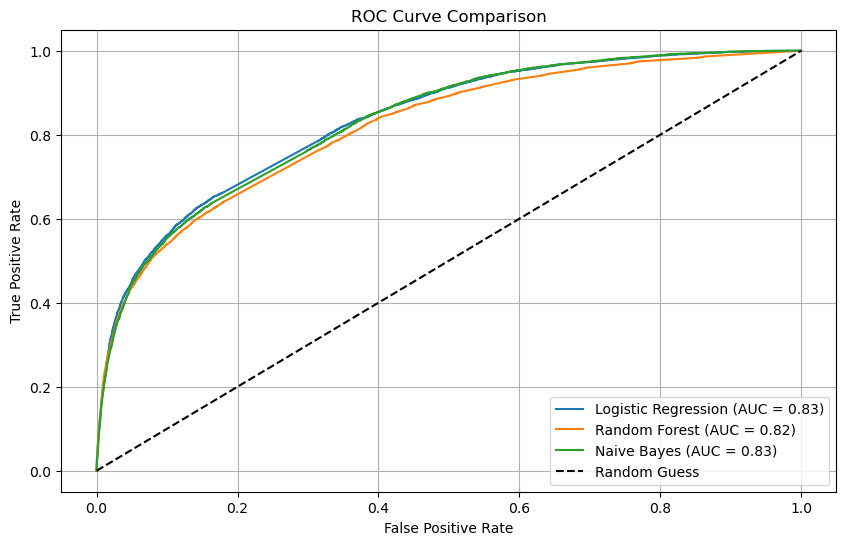

In [72]:
# Logistic Regression - Predict probabilities
y_pred_prob_logistic = model.predict_proba(X_test)[:, 1]  # Extra positive class

# Random Forest - Predict probabilities
y_pred_prob_rf = random_forest_model.predict_proba(X_test)[:, 1]  #  Extrapositive class

# Naive Bayes - Predict probabilities
y_pred_prob_NB = nb_classifier.predict_proba(X_test)[:, 1]  #  Extra positive class

# Calculate ROC curve and AUC for Logistic Regression
fpr_logistic, tpr_logistic, _ = roc_curve(y_test, y_pred_prob_logistic)
auc_logistic = roc_auc_score(y_test, y_pred_prob_logistic)

# Calculate ROC curve and AUC for Random Forest
fpr_rf, tpr_rf, _ = roc_curve(y_test, y_pred_prob_rf)
auc_rf = roc_auc_score(y_test, y_pred_prob_rf)

# Calculate ROC curve and AUC for Naive Bayes
fpr_NB, tpr_NB, _ = roc_curve(y_test, y_pred_prob_NB)
auc_NB = roc_auc_score(y_test, y_pred_prob_NB)

# Plot ROC Curves
plt.figure(figsize=(10, 6))
plt.plot(fpr_logistic, tpr_logistic, label=f"Logistic Regression (AUC = {auc_logistic:.2f})")
plt.plot(fpr_rf, tpr_rf, label=f"Random Forest (AUC = {auc_rf:.2f})")
plt.plot(fpr_NB, tpr_NB, label=f"Naive Bayes (AUC = {auc_NB:.2f})")
plt.plot([0, 1], [0, 1], 'k--', label="Random Guess")
plt.xlabel("False Positive Rate")
plt.ylabel("True Positive Rate")
plt.title("ROC Curve Comparison")
plt.legend()
plt.grid()
plt.show()

### 